In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import pickle
import csv
from tqdm.auto import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader



In [4]:


# ----------------------------
# Config paths
# ----------------------------
EDGES_POS = '/kaggle/input/nlp-cse-uoi-2025/data_new/edgelist.txt'
TEST_TXT  = '/kaggle/input/nlp-cse-uoi-2025/data_new/test.txt'
OUT_PKL   = 'graph_features_test.pkl'
OUT_CSV   = 'graph_features_test.csv'

# ----------------------------
# 1. Load positive edges and build graph
# ----------------------------
edges_pos = pd.read_csv(
    EDGES_POS,
    header=None,
    names=['u', 'v'],
    dtype={'u': int, 'v': int}
)
G = nx.Graph()
G.add_edges_from(edges_pos.values)
# Ensure isolated nodes are included (optional)
all_nodes = set(edges_pos.u) | set(edges_pos.v)
G.add_nodes_from(all_nodes)
print(f"Graph built: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")

# ----------------------------
# 2. Load test pairs
# ----------------------------
def load_test_pairs(fp: str) -> list:
    pairs = []
    with open(fp, encoding='utf-8') as fh:
        for ln in fh:
            ln = ln.strip()
            if not ln:
                continue
            try:
                u, v = map(int, ln.split(',')[:2])
                pairs.append((u, v))
            except ValueError:
                continue
    return pairs

test_pairs = load_test_pairs(TEST_TXT)
print(f"Loaded {len(test_pairs):,} test pairs.")

# ----------------------------
# 3. Define graph-based feature functions
# ----------------------------
def graph_features(u: int, v: int) -> np.ndarray:
    # Common neighbors (log1p scaled)
    try:
        cn = np.log1p(len(list(nx.common_neighbors(G, u, v))))
    except Exception:
        cn = 0.0
    # Preferential attachment (log1p scaled)
    try:
        pa_scores = list(nx.preferential_attachment(G, [(u, v)]))
        raw_pa = pa_scores[0][2] if pa_scores else 0
        pa = np.log1p(raw_pa)
    except Exception:
        pa = 0.0
    return np.array([cn, pa], dtype=np.float32)

# ----------------------------
# 4. Compute features for all test pairs
# ----------------------------
graph_feat_dict = {}
rows = []
for idx, (u, v) in enumerate(tqdm(test_pairs, desc='Computing graph features')):
    feat = graph_features(u, v)
    graph_feat_dict[(u, v)] = feat
    rows.append({'ID': idx, 'u': u, 'v': v, 'cn': float(feat[0]), 'pa': float(feat[1])})

# ----------------------------
# 5. Save outputs
# ----------------------------
# Pickle for code lookup
with open(OUT_PKL, 'wb') as f:
    pickle.dump(graph_feat_dict, f)
print(f"Saved pickle -> {OUT_PKL}")



Graph built: 138499 nodes, 1091955 edges.
Loaded 106,692 test pairs.


Computing graph features:   0%|          | 0/106692 [00:00<?, ?it/s]

Saved pickle -> graph_features_test.pkl


In [3]:
#LOGISTIC REGRESSION MODEL


# 1. Load precomputed raw embeddings and features

with open("/kaggle/input/scibert/scibert_embeddings.pkl", "rb") as f:
    bert_emb_raw = pickle.load(f)
with open("/kaggle/input/n2v-rich/node2vec_embeddings_train (1).pkl", "rb") as f:
    n2v_emb_raw = pickle.load(f)
with open("/kaggle/input/fine-tuned-embed/cls_embeddings (3).npy", "rb") as f:
    cls_emb_raw = np.load(f)
with open("/kaggle/input/graph-feats/graph_features (4).pkl", "rb") as f:
    graph_feats = pickle.load(f)


# 2. Load abstracts and edges

abstracts = []
with open("/kaggle/input/nlp-cse-uoi-2025/data_new/abstracts.txt", "r", encoding="utf-8") as f:
    for line in f:
        parts = line.split("|--|")
        abstracts.append(parts[1].strip().lower() if len(parts)==2 else line.strip().lower())

edges_pos = pd.read_csv(
    "/kaggle/input/nlp-cse-uoi-2025/data_new/edgelist.txt", header=None,
    names=["u", "v"], dtype=int
)
edges_pos["y"] = 1


# 3. Load authors

def load_authors(fp: str) -> dict:
    d = {}
    with open(fp, encoding="utf-8") as fh:
        for ln in fh:
            if "|--|" not in ln: continue
            pid_str, names = ln.rstrip().split("|--|",1)
            try:
                pid = int(pid_str)
                d[pid] = {n.strip() for n in names.split(",") if n.strip()}
            except:
                pass
    return d

paper_auth = load_authors("/kaggle/input/nlp-cse-uoi-2025/data_new/authors.txt")


# 4. Sample negatives and split

def sample_negatives(df, seed=42):
    rng = np.random.default_rng(seed)
    pos_set = set(map(tuple, df[["u","v"]].values))
    N = df[["u","v"]].values.max()+1
    neg = set()
    while len(neg) < len(df):
        u,v = rng.integers(0, N, size=2)
        if u!=v and (u,v) not in pos_set and (v,u) not in pos_set:
            neg.add((u,v))
    return pd.DataFrame(list(neg), columns=["u","v"]), N

edges_neg, num_nodes = sample_negatives(edges_pos)
edges_neg["y"] = 0
full = pd.concat([edges_pos, edges_neg], ignore_index=True)
train_df, test_df = train_test_split(full, test_size=0.2, stratify=full.y, random_state=42)


# 5. Fit PCA on train nodes

train_nodes = pd.unique(train_df[["u","v"]].values.ravel())
bert_mat = np.stack([bert_emb_raw[n] for n in train_nodes], axis=0)
n2v_mat  = np.stack([n2v_emb_raw[n] for n in train_nodes], axis=0)
cls_mat  = np.stack([cls_emb_raw[n] for n in train_nodes], axis=0)

pca_bert = PCA(n_components=55, random_state=42).fit(bert_mat)
pca_n2v  = PCA(n_components=108, random_state=42).fit(n2v_mat)
pca_cls  = PCA(n_components=32, random_state=42).fit(cls_mat)

# Transform raw
bert_emb = {n: pca_bert.transform(bert_emb_raw[n].reshape(1,-1))[0] for n in bert_emb_raw}
n2v_emb  = {n: pca_n2v.transform(n2v_emb_raw[n].reshape(1,-1))[0]  for n in n2v_emb_raw}
cls_emb  = {n: pca_cls.transform(cls_emb_raw[n].reshape(1,-1))[0]      for n in range(len(cls_emb_raw))}


# 6. Fit TF-IDF

vectorizer = TfidfVectorizer(max_features=10000, stop_words='english', min_df=20)
train_texts = [abstracts[n] for n in train_nodes]
vectorizer.fit(train_texts)
tfidf_matrix = vectorizer.transform(abstracts)


# 7. Feature builder

def tfidf_cosine(u,v):
    try:
        return float(cosine_similarity(tfidf_matrix[u], tfidf_matrix[v])[0,0])
    except:
        return 0.0

def author_feat_jaccard(u, v):
    Au = paper_auth.get(u, set())
    Av = paper_auth.get(v, set())
    inter = len(Au & Av)
    union = len(Au | Av)
    return 0.0 if union == 0 else inter / union



def build_features(df):
    X = []
    for u, v in tqdm(df[['u','v']].itertuples(index=False), total=len(df), desc="Building features"):
        # concatenate all embedding vectors into a dense one
        eu = np.concatenate([n2v_emb[u], cls_emb[u],bert_emb[u]])
        ev = np.concatenate([n2v_emb[v], cls_emb[v],bert_emb[v]])
        
        # difference & elementwise product
        diff = np.abs(eu - ev)
        prod = eu * ev
        
        # cosine similarity of the two combined embeddings
        sim = float(np.dot(eu, ev) /
                    (np.linalg.norm(eu) * np.linalg.norm(ev) + 1e-9))
        
        # recomputed graph-based features
        g = graph_feats.get((u, v),
                            graph_feats.get((v, u),
                                            np.zeros(2, dtype=np.float32)))
        
        # additional hand‐crafted similarities
        aj = author_feat_jaccard(u, v)
        tc = tfidf_cosine(u, v)
        meta = np.array([aj, tc, sim], dtype=np.float32)
        
        # final concatenation
        X.append(np.concatenate([eu, ev, diff, prod, g, meta]))
    
    return np.stack(X)



# 8. Train & eval

X_train = build_features(train_df)
X_test  = build_features(test_df)
y_train,y_test = train_df.y.values, test_df.y.values
scaler = StandardScaler().fit(X_train)
clf = LogisticRegression(penalty='l1', solver='saga', C=0.1, max_iter=5000, n_jobs=-1) #jobs=-1 to use all of the kaggle cores.
clf.fit(scaler.transform(X_train), y_train)
probs = clf.predict_proba(scaler.transform(X_test))[:,1]
preds = (probs>0.5).astype(int)
print('Log-loss:', log_loss(y_test, probs))
print('AUROC   :', roc_auc_score(y_test, probs))
print('F1      :', f1_score(y_test, preds))


# 9. Save artifacts for more future testing

with open('pca_bert.pkl','wb') as f: pickle.dump(pca_bert,f)
with open('pca_n2v.pkl','wb')  as f: pickle.dump(pca_n2v,f)
with open('pca_cls.pkl','wb')  as f: pickle.dump(pca_cls,f)
with open('tfidf_vect.pkl','wb') as f: pickle.dump(vectorizer,f)
with open('scaler.pkl','wb')    as f: pickle.dump(scaler,f)
with open('logreg_model.pkl','wb') as f: pickle.dump(clf,f)
print('✅ Saved all artifacts')


Building features:   0%|          | 0/1747128 [00:00<?, ?it/s]

Building features:   0%|          | 0/436782 [00:00<?, ?it/s]

Log-loss: 0.04476826637443463
AUROC   : 0.9981380610441152
F1      : 0.9861960478120586
✅ Saved all artifacts


In [6]:
#TESTING OUR OWN PAIRS 



# Config & paths

EDGES_POS       = '/kaggle/input/nlp-cse-uoi-2025/data_new/edgelist.txt'
TEST_TXT        = '/kaggle/input/nlp-cse-uoi-2025/data_new/test.txt'
ABSTRACTS_TXT   = '/kaggle/input/nlp-cse-uoi-2025/data_new/abstracts.txt'
AUTHORS_PATH    = '/kaggle/input/nlp-cse-uoi-2025/data_new/authors.txt'

PCA_BERT_PATH   = 'pca_bert.pkl'
PCA_N2V_PATH    = 'pca_n2v.pkl'
PCA_CLS_PATH    = 'pca_cls.pkl'
TFIDF_VECT_PATH = 'tfidf_vect.pkl'
SCALER_PATH     = 'scaler.pkl'
MODEL_PATH      = 'logreg_model.pkl'
GRAPH_FEAT_PATH = 'graph_features_test.pkl'

OUTPUT_SUB_PATH = 'submission.csv'

# 1. Load artifacts

with open(PCA_BERT_PATH,   'rb') as f: pca_bert    = pickle.load(f)
with open(PCA_N2V_PATH,    'rb') as f: pca_n2v     = pickle.load(f)
with open(PCA_CLS_PATH,    'rb') as f: pca_cls     = pickle.load(f)
with open(TFIDF_VECT_PATH, 'rb') as f: tfidf_vect  = pickle.load(f)
with open(SCALER_PATH,     'rb') as f: scaler      = pickle.load(f)
with open(MODEL_PATH,      'rb') as f: model       = pickle.load(f)
with open(GRAPH_FEAT_PATH, 'rb') as f: graph_feats = pickle.load(f)

# Raw embeddings
with open('/kaggle/input/scibert/scibert_embeddings.pkl','rb') as f:
    bert_raw = pickle.load(f)
with open('/kaggle/input/n2v-rich/node2vec_embeddings_train (1).pkl','rb') as f:
    n2v_raw  = pickle.load(f)
cls_raw = np.load('/kaggle/input/fine-tuned-embed/cls_embeddings (3).npy')


# 2. Load abstracts & build TF-IDF matrix

abstracts = []
with open(ABSTRACTS_TXT,'r',encoding='utf-8') as f:
    for ln in f:
        parts = ln.split('|--|')
        abstracts.append(parts[1].strip().lower() if len(parts)==2 else ln.strip().lower())

tfidf_matrix = tfidf_vect.transform(abstracts)


# 3. Load authors

paper_auth = {}
with open(AUTHORS_PATH,'r',encoding='utf-8') as fh:
    for ln in fh:
        if '|--|' not in ln: continue
        pid, names = ln.rstrip().split('|--|',1)
        try:
            i = int(pid)
            paper_auth[i] = {n.strip() for n in names.split(',') if n.strip()}
        except:
            pass

# 4. Load test pairs

test_pairs = []
with open(TEST_TXT,'r') as f:
    for ln in f:
        ln=ln.strip()
        if not ln: continue
        u,v = map(int, ln.split(',')[:2])
        test_pairs.append((u,v))


# 5. Helper fns

def tfidf_cosine(u,v):
    try:
        return float(cosine_similarity(tfidf_matrix[u], tfidf_matrix[v])[0,0])
    except:
        return 0.0

def author_feat_jaccard(u, v):
    Au = paper_auth.get(u, set())
    Av = paper_auth.get(v, set())
    inter = len(Au & Av)
    union = len(Au | Av)
    return 0.0 if union == 0 else inter/union


# 6. Build features

X = []
for u,v in tqdm(test_pairs, desc='Building features'):
    # PCA embeddings
   
    nu = pca_n2v.transform(n2v_raw[u].reshape(1, -1))[0] if u in n2v_raw else np.zeros(pca_n2v.n_components_)
    cu = pca_cls.transform(cls_raw[u].reshape(1, -1))[0] if u < len(cls_raw) else np.zeros(pca_cls.n_components_)
    su = pca_bert.transform(bert_raw[u].reshape(1, -1))[0] if u < len(bert_raw) else np.zeros(pca_sci.n_components_)

    nv = pca_n2v.transform(n2v_raw[v].reshape(1, -1))[0] if v in n2v_raw else np.zeros(pca_n2v.n_components_)
    cv = pca_cls.transform(cls_raw[v].reshape(1, -1))[0] if v < len(cls_raw) else np.zeros(pca_cls.n_components_)
    sv = pca_bert.transform(bert_raw[v].reshape(1, -1))[0] if v < len(bert_raw) else np.zeros(pca_sci.n_components_)

    eu = np.concatenate([nu, cu, su])
    ev = np.concatenate([nv, cv, sv])

    # interactions & similarity
    diff = np.abs(eu-ev)
    prod = eu*ev
    sims = float(np.dot(eu,ev)/(np.linalg.norm(eu)*np.linalg.norm(ev)+1e-9))
    # graph
    g = graph_feats.get((u,v), graph_feats.get((v,u), np.zeros(2,dtype=np.float32)))
    # author & tfidf
    aj = author_feat_jaccard(u,v)
    tc    = tfidf_cosine(u,v)
    meta  = np.array([aj,tc,sims],dtype=np.float32)
    # concat
    X.append(np.concatenate([eu,ev,diff,prod,g,meta]))

X = np.stack(X)


# 7. Scale, predict & save

X_s   = scaler.transform(X)
probs = model.predict_proba(X_s)[:,1]

import csv
with open(OUTPUT_SUB_PATH,'w',newline='') as fout:
    w=csv.writer(fout)
    w.writerow(['ID','Label'])
    for i,p in enumerate(probs):
        w.writerow([i,f"{p:.6f}"])

print(f"✅ submission saved to {OUTPUT_SUB_PATH}")


Building features:   0%|          | 0/106692 [00:00<?, ?it/s]

✅ submission saved to submission.csv


In [1]:
#XGBoost classifier
import os
import numpy as np
import pandas as pd
import pickle
from tqdm.auto import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, roc_auc_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
import networkx as nx


# 1. Load precomputed raw embeddings and features


with open("/kaggle/input/scibert/scibert_embeddings.pkl", "rb") as f:
    bert_emb_raw = pickle.load(f)    # now SciBERT CLS vectors
with open("/kaggle/input/n2v-rich/node2vec_embeddings_train (1).pkl", "rb") as f:
    n2v_emb_raw = pickle.load(f)
with open("/kaggle/input/fine-tuned-embed/cls_embeddings (3).npy", "rb") as f:
    cls_emb_raw = np.load(f)
with open("/kaggle/input/graph-feats/graph_features (4).pkl", "rb") as f:
    graph_feats = pickle.load(f)


# 2. Load abstracts and positive edges
-
abstracts = []
with open("/kaggle/input/nlp-cse-uoi-2025/data_new/abstracts.txt", "r", encoding="utf-8") as f:
    for line in f:
        parts = line.split("|--|")
        abstracts.append(parts[1].strip().lower() if len(parts)==2 else line.strip().lower())

edges_pos = pd.read_csv(
    "/kaggle/input/nlp-cse-uoi-2025/data_new/edgelist.txt",
    header=None, names=["u", "v"], dtype=int
)
edges_pos["y"] = 1


# 3. Load authors mapping

def load_authors(fp: str) -> dict:
    d = {}
    with open(fp, encoding="utf-8") as fh:
        for ln in fh:
            if "|--|" not in ln:
                continue
            pid_str, names = ln.rstrip().split("|--|",1)
            try:
                pid = int(pid_str)
                d[pid] = {n.strip() for n in names.split(",") if n.strip()}
            except:
                pass
    return d

paper_auth = load_authors("/kaggle/input/nlp-cse-uoi-2025/data_new/authors.txt")


# 4. Sample negatives and train/test split

def sample_negatives(df, seed=42):
    rng = np.random.default_rng(seed)
    pos_set = set(map(tuple, df[["u","v"]].values))
    N = df[["u","v"]].values.max() + 1
    neg = set()
    while len(neg) < len(df):
        u, v = rng.integers(0, N, size=2)
        if u != v and (u, v) not in pos_set and (v, u) not in pos_set:
            neg.add((u, v))
    return pd.DataFrame(list(neg), columns=["u","v"]), N

edges_neg, num_nodes = sample_negatives(edges_pos)
edges_neg["y"] = 0

full = pd.concat([edges_pos, edges_neg], ignore_index=True)
train_df, test_df = train_test_split(full, test_size=0.2, stratify=full.y, random_state=42)

# 5. Fit PCA on train node embeddings

train_nodes = pd.unique(train_df[["u","v"]].values.ravel())
bert_mat = np.stack([bert_emb_raw[n] for n in train_nodes], axis=0)
n2v_mat  = np.stack([n2v_emb_raw[n] for n in train_nodes], axis=0)
cls_mat  = np.stack([cls_emb_raw[n] for n in train_nodes], axis=0)

pca_bert = PCA(n_components=56, random_state=42).fit(bert_mat)   # SciBERT PCA
pca_n2v  = PCA(n_components=100, random_state=42).fit(n2v_mat)
pca_cls  = PCA(n_components=40, random_state=42).fit(cls_mat)

bert_emb = {n: pca_bert.transform(bert_emb_raw[n].reshape(1,-1))[0] for n in bert_emb_raw}
n2v_emb  = {n: pca_n2v.transform(n2v_emb_raw[n].reshape(1,-1))[0]  for n in n2v_emb_raw}
cls_emb  = {n: pca_cls.transform(cls_emb_raw[n].reshape(1,-1))[0]      for n in range(len(cls_emb_raw))}


# 6. Fit TF-IDF on abstracts

vectorizer   = TfidfVectorizer(max_features=10000, stop_words='english', min_df=20)
train_texts  = [abstracts[n] for n in train_nodes]
vectorizer.fit(train_texts)
tfidf_matrix = vectorizer.transform(abstracts)


# 7. Feature builder

def tfidf_cosine(u, v):
    try:
        return float(cosine_similarity(tfidf_matrix[u], tfidf_matrix[v])[0,0])
    except:
        return 0.0

def author_feat_jaccard(u, v):
    Au = paper_auth.get(u, set())
    Av = paper_auth.get(v, set())
    inter = len(Au & Av)
    union = len(Au | Av)
    return 0.0 if union == 0 else inter / union

def build_features(df):
    X = []
    for u, v in tqdm(df[['u','v']].itertuples(index=False), total=len(df), desc="Building features"):
        # combine node2vec + CLS + SciBERT PCA embeddings
        eu = np.concatenate([n2v_emb[u], cls_emb[u], bert_emb[u]])
        ev = np.concatenate([n2v_emb[v], cls_emb[v], bert_emb[v]])

        # diff & product
        diff = np.abs(eu - ev)
        prod = eu * ev
        
        # cosine similarity
        sim = float(np.dot(eu, ev) /
                    (np.linalg.norm(eu) * np.linalg.norm(ev) + 1e-9))
        
        # graph-based features
        g = graph_feats.get((u, v),
                            graph_feats.get((v, u),
                                            np.zeros(2, dtype=np.float32)))
        
        # meta-features
        aj = author_feat_jaccard(u, v)
        tc = tfidf_cosine(u, v)
        meta = np.array([aj, tc, sim], dtype=np.float32)
        
        X.append(np.concatenate([eu, ev, diff, prod, g, meta]))
    return np.stack(X)

X_train = build_features(train_df)
X_test  = build_features(test_df)
y_train = train_df.y.values
y_test  = test_df.y.values


# 8. Train & eval with XGBoost

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

clf = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,  gg
    random_state=42,
    n_jobs=-1
)

clf.fit(
    X_train_scaled, y_train,
    eval_set=[(X_test_scaled, y_test)],
    early_stopping_rounds=50,
    verbose=True
)

probs = clf.predict_proba(X_test_scaled)[:, 1]
preds = (probs > 0.5).astype(int)

print('Log-loss:', log_loss(y_test, probs))
print('AUROC   :', roc_auc_score(y_test, probs))
print('F1      :', f1_score(y_test, preds))

# ----------------------------
# 9. Save artifacts
# ----------------------------
with open('pca_bert.pkl','wb')   as f: pickle.dump(pca_bert, f)
with open('pca_n2v.pkl','wb')    as f: pickle.dump(pca_n2v, f)
with open('pca_cls.pkl','wb')    as f: pickle.dump(pca_cls, f)
with open('tfidf_vect.pkl','wb') as f: pickle.dump(vectorizer, f)
with open('scaler.pkl','wb')     as f: pickle.dump(scaler, f)
with open('xgb_model.pkl','wb')  as f: pickle.dump(clf, f)

print('✅ Saved all artifacts')

Building features:   0%|          | 0/1747128 [00:00<?, ?it/s]

Building features:   0%|          | 0/436782 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.65603
[1]	validation_0-logloss:0.62171
[2]	validation_0-logloss:0.59056
[3]	validation_0-logloss:0.56185
[4]	validation_0-logloss:0.53586
[5]	validation_0-logloss:0.51204
[6]	validation_0-logloss:0.48981
[7]	validation_0-logloss:0.46954
[8]	validation_0-logloss:0.45092
[9]	validation_0-logloss:0.43350
[10]	validation_0-logloss:0.41745
[11]	validation_0-logloss:0.40148
[12]	validation_0-logloss:0.38640
[13]	validation_0-logloss:0.37235
[14]	validation_0-logloss:0.35966
[15]	validation_0-logloss:0.34736
[16]	validation_0-logloss:0.33614
[17]	validation_0-logloss:0.32492
[18]	validation_0-logloss:0.31446
[19]	validation_0-logloss:0.30468
[20]	validation_0-logloss:0.29584
[21]	validation_0-logloss:0.28733
[22]	validation_0-logloss:0.27928
[23]	validation_0-logloss:0.27172
[24]	validation_0-logloss:0.26458
[25]	validation_0-logloss:0.25721
[26]	validation_0-logloss:0.25023
[27]	validation_0-logloss:0.24360
[28]	validation_0-logloss:0.23740
[29]	validation_0-loglos

In [3]:
#TESTING SCRIPT FOR MY XGBoost


# Config & paths

TEST_TXT         = '/kaggle/input/nlp-cse-uoi-2025/data_new/test.txt'
ABSTRACTS_TXT    = '/kaggle/input/nlp-cse-uoi-2025/data_new/abstracts.txt'
AUTHORS_PATH     = '/kaggle/input/nlp-cse-uoi-2025/data_new/authors.txt'

PCA_N2V_PATH     = 'pca_n2v.pkl'
PCA_CLS_PATH     = 'pca_cls.pkl'
PCA_BERT_PATH    = 'pca_bert.pkl'        
TFIDF_VECT_PATH  = 'tfidf_vect.pkl'
SCALER_PATH      = 'scaler.pkl'
MODEL_PATH       = 'xgb_model.pkl'
GRAPH_FEAT_PATH  = '/kaggle/working/graph_features_test.pkl'

OUTPUT_SUB_PATH  = 'submission.csv'

# 1. Load preprocessing artifacts & model

with open(PCA_N2V_PATH,    'rb') as f: pca_n2v    = pickle.load(f)
with open(PCA_CLS_PATH,    'rb') as f: pca_cls    = pickle.load(f)
with open(PCA_BERT_PATH,   'rb') as f: pca_bert   = pickle.load(f)    
with open(TFIDF_VECT_PATH, 'rb') as f: tfidf_vect = pickle.load(f)
with open(SCALER_PATH,     'rb') as f: scaler     = pickle.load(f)
with open(MODEL_PATH,      'rb') as f: model      = pickle.load(f)
with open(GRAPH_FEAT_PATH, 'rb') as f: graph_feats= pickle.load(f)


# 2. Load raw embeddings

with open('/kaggle/input/scibert/scibert_embeddings.pkl','rb') as f:
    bert_raw = pickle.load(f)                     # ← new
with open('/kaggle/input/n2v-rich/node2vec_embeddings_train (1).pkl','rb') as f:
    n2v_raw  = pickle.load(f)
cls_raw = np.load('/kaggle/input/fine-tuned-embed/cls_embeddings (3).npy')


# 3. Load abstracts & build TF-IDF matrix

abstracts = []
with open(ABSTRACTS_TXT, 'r', encoding='utf-8') as f:
    for ln in f:
        parts = ln.split('|--|')
        abstracts.append(parts[1].strip().lower() if len(parts)==2 else ln.strip().lower())

tfidf_matrix = tfidf_vect.transform(abstracts)


# 4. Load authors mapping

paper_auth = {}
with open(AUTHORS_PATH, 'r', encoding='utf-8') as fh:
    for ln in fh:
        if '|--|' not in ln:
            continue
        pid, names = ln.rstrip().split('|--|', 1)
        try:
            i = int(pid)
            paper_auth[i] = {n.strip() for n in names.split(',') if n.strip()}
        except:
            pass

# 5. Load test pairs

test_pairs = []
with open(TEST_TXT, 'r') as f:
    for ln in f:
        ln = ln.strip()
        if not ln:
            continue
        u, v = map(int, ln.split(',')[:2])
        test_pairs.append((u, v))


# 6. Helper fns

def tfidf_cosine(u, v):
    try:
        return float(cosine_similarity(tfidf_matrix[u], tfidf_matrix[v])[0,0])
    except:
        return 0.0

def author_feat_jaccard(u, v):
    Au = paper_auth.get(u, set())
    Av = paper_auth.get(v, set())
    inter = len(Au & Av)
    union = len(Au | Av)
    return 0.0 if union == 0 else inter / union


# 7. Build features for test set

X = []
for u, v in tqdm(test_pairs, desc='Building features'):
    # PCA embeddings for node2vec, CLS &  Sci-BERT
    nu = pca_n2v.transform(n2v_raw[u].reshape(1, -1))[0]  if u in n2v_raw else np.zeros(pca_n2v.n_components_)
    nv = pca_n2v.transform(n2v_raw[v].reshape(1, -1))[0]  if v in n2v_raw else np.zeros(pca_n2v.n_components_)
    cu = pca_cls.transform(cls_raw[u].reshape(1, -1))[0]  if u < len(cls_raw) else np.zeros(pca_cls.n_components_)
    cv = pca_cls.transform(cls_raw[v].reshape(1, -1))[0]  if v < len(cls_raw) else np.zeros(pca_cls.n_components_)
    bu = pca_bert.transform(bert_raw[u].reshape(1, -1))[0] if u in bert_raw else np.zeros(pca_bert.n_components_)
    bv = pca_bert.transform(bert_raw[v].reshape(1, -1))[0] if v in bert_raw else np.zeros(pca_bert.n_components_)

    # final “embedding” vectors
    eu = np.concatenate([nu, cu,bu])
    ev = np.concatenate([nv, cv,bv])

 
    diff = np.abs(eu - ev)
    prod = eu * ev
  
    sim = float(np.dot(eu, ev) /
                    (np.linalg.norm(eu) * np.linalg.norm(ev) + 1e-9))
        
     
    g = graph_feats.get((u, v), graph_feats.get((v, u), np.zeros(2, dtype=np.float32)))
    aj = author_feat_jaccard(u, v)
    tc = tfidf_cosine(u, v)
    meta = np.array([aj, tc, sim], dtype=np.float32)

        # Now all components are 1D arrays
    X.append(np.concatenate([eu, ev, diff, prod, g, meta]))
X = np.stack(X)
# ----------------------------
# 8. Scale, predict & save
# ----------------------------
X_s   = scaler.transform(X)
probs = model.predict_proba(X_s)[:, 1]

import csv
with open(OUTPUT_SUB_PATH, 'w', newline='') as fout:
    writer = csv.writer(fout)
    writer.writerow(['ID', 'Label'])
    for i, p in enumerate(probs):
        writer.writerow([i, f"{p:.6f}"])

print(f" submission saved to {OUTPUT_SUB_PATH}")


Building features:   0%|          | 0/106692 [00:00<?, ?it/s]

 submission saved to submission.csv


In [ ]:
#CNN MODEL USING PYTORCH
# ------------------------------------------------------------------
# 0) Imports
# ------------------------------------------------------------------


device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


# 1) Load data

AUTHORS = "/kaggle/input/nlp-cse-uoi-2025/data_new/authors.txt"
EDGES   = "/kaggle/input/nlp-cse-uoi-2025/data_new/edgelist.txt"
BERT_EMB = "/kaggle/input/scibert/scibert_embeddings.pkl"
NODE2VEC_EMB = "/kaggle/input/n2v-rich/node2vec_embeddings_train (1).pkl"
GRAPH_FEAT = "/kaggle/input/gfeat-with-3-feats/graph_features_enriched_leakfree (4).pkl"
CLS_EMB_NPY = "/kaggle/input/fine-tuned-embed/cls_embeddings (3).npy"
ABSTRACTS_TXT = "/kaggle/input/nlp-cse-uoi-2025/data_new/abstracts.txt"

with open(BERT_EMB, "rb") as f:
    bert_embeddings = pickle.load(f)
print(f"Loaded {len(bert_embeddings)} SBERT embeddings.")

with open(NODE2VEC_EMB, "rb") as f:
    node2vec_embeddings = pickle.load(f)
print(f"Loaded {len(node2vec_embeddings)} Node2Vec embeddings.")

with open(GRAPH_FEAT, "rb") as f:
    graph_features = pickle.load(f)
print(f"Loaded {len(graph_features)} graph features.")

cls_np = np.load(CLS_EMB_NPY)
cls_embeddings = {pid: cls_np[i] for i, pid in enumerate(bert_embeddings.keys())}

# Load abstracts for TF-IDF
abstracts = []
with open(ABSTRACTS_TXT, "r", encoding="utf-8") as f:
    for line in f:
        parts = line.split("|--|")
        text = parts[1].strip().lower() if len(parts) == 2 else line.strip().lower()
        abstracts.append(text)


# 2) Load authors and edges

def load_authors(fp):
    d = {}
    with open(fp, encoding="utf-8") as fh:
        for ln in fh:
            if "|--|" not in ln: continue
            pid, names = ln.rstrip().split("|--|", 1)
            try: pid = int(pid)
            except ValueError: continue
            d[pid] = {n.strip() for n in names.split(",") if n.strip()}
    return d

paper_auth = load_authors(AUTHORS)
edges_pos  = pd.read_csv(EDGES, header=None, names=["u", "v"])
N          = len(bert_embeddings)

print(f"Total papers with SBERT embeddings: {N} | Positives: {len(edges_pos):,}")


# 3) Negative sampling

rng = np.random.default_rng(42)
neg = set()


edges_pos_set = set(tuple(sorted(edge)) for edge in edges_pos)

while len(neg) < len(edges_pos):
    a, b = rng.integers(N, size=2)
    if a != b:
        edge = tuple(sorted((a, b)))  # unordered pair
        if edge not in edges_pos_set:
            neg.add(edge)

edges_neg = pd.DataFrame(list(neg), columns=["u", "v"])



# 4) Author-overlap helper

def author_feats(u, v):
    Au, Av = paper_auth.get(u, ()), paper_auth.get(v, ())
    inter = len(Au & Av)
    if not (Au or Av): return 0, 0.0
    jac = inter / (len(Au) + len(Av) - inter) if inter else 0.0
    return inter, jac


# 5) TF-IDF similarity

vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(abstracts)

def tfidf_cosine(u, v):
    try:
        return float(cosine_similarity(tfidf_matrix[u], tfidf_matrix[v])[0, 0])
    except:
        return 0.0

# 6) Dataset with SBERT + Node2Vec + Graph Feats + CLS Cosine

class PairDataset(Dataset):
    def __init__(self, df, y):
        self.df = df.reset_index(drop=True)
        self.y  = y.astype(np.float32)

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        u, v = self.df.iloc[idx]

        vu_sbert = bert_embeddings.get(int(u), np.zeros(768, dtype=np.float32))
        vv_sbert = bert_embeddings.get(int(v), np.zeros(768, dtype=np.float32))
        vu_n2v = node2vec_embeddings.get(int(u), np.zeros(128, dtype=np.float32))
        vv_n2v = node2vec_embeddings.get(int(v), np.zeros(128, dtype=np.float32))
        vu_cls = cls_embeddings.get(int(u), np.zeros(768, dtype=np.float32))
        vv_cls = cls_embeddings.get(int(v), np.zeros(768, dtype=np.float32))

        vu = np.concatenate([vu_sbert, vu_n2v])
        vv = np.concatenate([vv_sbert, vv_n2v])

        x6 = np.stack([vu, vv, np.abs(vu - vv), vu * vv], axis=0).astype(np.float32)

        inter, jac = author_feats(int(u), int(v))
        cos = float(np.dot(vu, vv) / (np.linalg.norm(vu) * np.linalg.norm(vv) + 1e-9))
        eucl = float(np.linalg.norm(vu - vv))
        sim_bert = cos
        tfidf_sim = tfidf_cosine(int(u), int(v))
        cos_cls = float(np.dot(vu_cls, vv_cls) / (np.linalg.norm(vu_cls) * np.linalg.norm(vv_cls) + 1e-9))
        gfeat = graph_features.get((int(u), int(v)), np.zeros(3, dtype=np.float32))

        meta = np.concatenate([np.array([inter, jac, cos, eucl, sim_bert, tfidf_sim, cos_cls], dtype=np.float32), gfeat])

        return (
            torch.from_numpy(x6),
            torch.from_numpy(meta),
            torch.tensor(self.y[idx])
        )


# 7) Train/test split & loaders

full_X = pd.concat([edges_pos, edges_neg], ignore_index=True)
full_y = np.concatenate([np.ones(len(edges_pos)), np.zeros(len(edges_neg))])

tr_idx, te_idx = train_test_split(np.arange(len(full_y)),
                                  test_size=0.2,
                                  stratify=full_y,
                                  random_state=42)

train_ds = PairDataset(full_X.iloc[tr_idx], full_y[tr_idx])
test_ds  = PairDataset(full_X.iloc[te_idx],  full_y[te_idx])

BATCH = 128
train_loader = DataLoader(train_ds, BATCH, shuffle=True,  num_workers=4, drop_last=True)
test_loader  = DataLoader(test_ds,  BATCH, shuffle=False, num_workers=4)


# 8) CNN (input = 4 channels, 448 dims per emb)

class PairCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(4, 32, 5, padding=2), nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 5, padding=2), nn.ReLU(),
            nn.MaxPool1d(2)
        )

        # Automatically calculate output dimension
        with torch.no_grad():
            dummy = torch.zeros(1, 4, 896)  # 896 = input dim per emb
            out_dim = self.conv(dummy).flatten(1).shape[1]

        self.fc = nn.Sequential(
            nn.Linear(out_dim + 10, 128),  # 10 meta features
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128, 1)
        )


    def forward(self, x6, meta):
        z = self.conv(x6).flatten(1)
        z = torch.cat([z, meta], dim=1)
        return self.fc(z).squeeze(1)

model = PairCNN().to(device)
opt   = torch.optim.Adam(model.parameters(), lr=2e-4)
lossf = nn.BCEWithLogitsLoss()


# 9) Train with best model tracking

EPOCHS =12
best_loss = float("inf")

for ep in range(1, EPOCHS + 1):
    model.train(); tr_losses = []
    for x6, meta, y in tqdm(train_loader, desc=f"ep{ep}", leave=False):
        x6, meta, y = x6.to(device), meta.to(device), y.to(device)
        opt.zero_grad()
        logits = model(x6, meta)
        loss = lossf(logits, y)
        loss.backward(); opt.step()
        tr_losses.append(loss.item())

    model.eval(); probs, y_true = [], []
    with torch.no_grad():
        for x6, meta, y in test_loader:
            logits = model(x6.to(device), meta.to(device))
            probs.append(torch.sigmoid(logits).cpu().numpy())
            y_true.append(y.numpy())

    probs = np.concatenate(probs)
    y_true = np.concatenate(y_true)
    y_pred = (probs > 0.5).astype(np.uint8)

    val_auc = roc_auc_score(y_true, probs)
    val_log = log_loss(y_true, probs)
    val_f1  = f1_score(y_true, y_pred)

    print(f"Epoch {ep} | Train loss: {np.mean(tr_losses):.4f} | "
          f"Val AUROC: {val_auc:.4f} | F1: {val_f1:.4f} | Log-loss: {val_log:.4f}")

    if val_log < best_loss:
        best_loss = val_log
        torch.save(model.state_dict(), "best_model_sbert_n2v.pt")
        print(f" Saved model at epoch {ep} with log loss {val_log:.4f}")


# 10) Final Evaluation

model.load_state_dict(torch.load("best_model_sbert_n2v.pt"))
model.eval(); probs = []
with torch.no_grad():
    for x6, meta, _ in test_loader:
        logits = model(x6.to(device), meta.to(device))
        probs.append(torch.sigmoid(logits).cpu().numpy())
probs = np.concatenate(probs)

print("Final evaluation on test set:")
print("AUROC   :", roc_auc_score(full_y[te_idx], probs))
print("Log-loss:", log_loss(full_y[te_idx],  probs))

Device: cpu
Loaded 138499 SBERT embeddings.
Loaded 138499 Node2Vec embeddings.
Loaded 3 graph features.
Total papers with SBERT embeddings: 138499 | Positives: 1,091,955


ep1:   0%|          | 0/13649 [00:00<?, ?it/s]

In [ ]:
#CNN TESTING SCRIPT

# 1) Load all resources


# Paths
BERT_EMB     = "/kaggle/input/bert-embed/bert_embeddings.pkl"
NODE2VEC_EMB = "/kaggle/working/node2vec_embeddings_train80.pkl"
CLS_EMB_NPY  = "/kaggle/input/embeddings/cls_embeddings.npy"
GRAPH_FEAT   = "/kaggle/working/graph_features_test.pkl"
AUTHORS_PATH = "/kaggle/input/nlp-cse-uoi-2025/data_new/authors.txt"
TEST_TXT     = "/kaggle/input/nlp-cse-uoi-2025/data_new/test.txt"
MODEL_PATH   = "/kaggle/working/best_model_sbert_n2v.pt"
ABSTRACTS_TXT = "/kaggle/input/nlp-cse-uoi-2025/data_new/abstracts.txt"

# Load embeddings
with open(BERT_EMB, "rb") as f:
    bert_embeddings = pickle.load(f)
with open(NODE2VEC_EMB, "rb") as f:
    node2vec_embeddings = pickle.load(f)
cls_np = np.load(CLS_EMB_NPY)
cls_embeddings = {pid: cls_np[i] for i, pid in enumerate(bert_embeddings.keys())}
with open(GRAPH_FEAT, "rb") as f:
    graph_features = pickle.load(f)

# Load authors
paper_auth = {}
with open(AUTHORS_PATH, encoding="utf-8") as fh:
    for ln in fh:
        if "|--|" in ln:
            pid, names = ln.rstrip().split("|--|", 1)
            try:
                paper_auth[int(pid)] = {n.strip() for n in names.split(",") if n.strip()}
            except ValueError:
                continue

# Load abstracts and compute TF-IDF
abstracts = []
with open(ABSTRACTS_TXT, "r", encoding="utf-8") as f:
    for line in f:
        parts = line.split("|--|")
        text = parts[1].strip().lower() if len(parts) == 2 else line.strip().lower()
        abstracts.append(text)

vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(abstracts)


# 2) CNN Model — Matches Saved Model Architecture

class PairCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(4, 32, 5, padding=2), nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 5, padding=2), nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 112 + 9, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, x6, meta):
        z = self.conv(x6).flatten(1)
        z = torch.cat([z, meta], dim=1)
        return self.fc(z).squeeze(1)


# 3) Load pretrained model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PairCNN().to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()
print("✅ Model loaded.")


# 4) Utility functions

def load_test_pairs(fp):
    pairs = []
    with open(fp, encoding="utf-8") as fh:
        for ln in fh:
            if ln.strip():
                try:
                    u, v = map(int, ln.strip().split(",")[:2])
                    pairs.append((u, v))
                except ValueError:
                    continue
    return pairs

def author_feats(u, v):
    Au, Av = paper_auth.get(u, set()), paper_auth.get(v, set())
    inter = len(Au & Av)
    if not (Au or Av): return 0, 0.0
    jac = inter / (len(Au) + len(Av) - inter) if inter else 0.0
    return inter, jac

def tfidf_cosine(u, v):
    try:
        return float(cosine_similarity(tfidf_matrix[u], tfidf_matrix[v])[0, 0])
    except:
        return 0.0


# 5) Dataset for inference — Matches saved model input

class TestPairDS(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs

    def __len__(self): return len(self.pairs)

    def __getitem__(self, idx):
        u, v = self.pairs[idx]

        vu_sbert = bert_embeddings.get(u, np.zeros(384, dtype=np.float32))
        vv_sbert = bert_embeddings.get(v, np.zeros(384, dtype=np.float32))
        vu_n2v   = node2vec_embeddings.get(u, np.zeros(64, dtype=np.float32))
        vv_n2v   = node2vec_embeddings.get(v, np.zeros(64, dtype=np.float32))
        vu_cls   = cls_embeddings.get(u, np.zeros(768, dtype=np.float32))
        vv_cls   = cls_embeddings.get(v, np.zeros(768, dtype=np.float32))

        vu = np.concatenate([vu_sbert, vu_n2v])
        vv = np.concatenate([vv_sbert, vv_n2v])
        x6 = np.stack([vu, vv, np.abs(vu - vv), vu * vv], axis=0).astype(np.float32)

        inter, jac = author_feats(u, v)
        cos        = float(np.dot(vu, vv) / (np.linalg.norm(vu) * np.linalg.norm(vv) + 1e-9))
        eucl       = float(np.linalg.norm(vu - vv))
        tfidf_sim  = tfidf_cosine(u, v)
        cos_cls    = float(np.dot(vu_cls, vv_cls) / (np.linalg.norm(vu_cls) * np.linalg.norm(vv_cls) + 1e-9))

        gfeat = graph_features.get((u, v))
        if gfeat is None:
            gfeat = graph_features.get((v, u))
        if gfeat is None:
            gfeat = np.zeros(2, dtype=np.float32)

        meta = np.concatenate([np.array([inter, jac, cos, eucl, cos, tfidf_sim, cos_cls], dtype=np.float32), gfeat])
        return torch.from_numpy(x6), torch.from_numpy(meta)


# 6) Inference

test_pairs = load_test_pairs(TEST_TXT)
loader = DataLoader(TestPairDS(test_pairs), batch_size=1024, num_workers=2, pin_memory=True)

print(f"🔍 Loaded {len(test_pairs):,} test pairs.")

probs = []
with torch.no_grad():
    for x6, meta in tqdm(loader, desc="Inference"):
        x6, meta = x6.to(device), meta.to(device)
        logits = model(x6, meta)
        probs.append(torch.sigmoid(logits).cpu().numpy())

y_prob = np.concatenate(probs)
print(" Predictions shape:", y_prob.shape)
print(" Min:", y_prob.min(), "Max:", y_prob.max(), "Mean:", y_prob.mean())


# 7) Save predictions

with open("test_predictions.csv", "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["ID", "Label"])
    for i, p in enumerate(y_prob):
        w.writerow([i, f"{p:.6f}"])

print(" Saved predictions to test_predictions.csv")


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


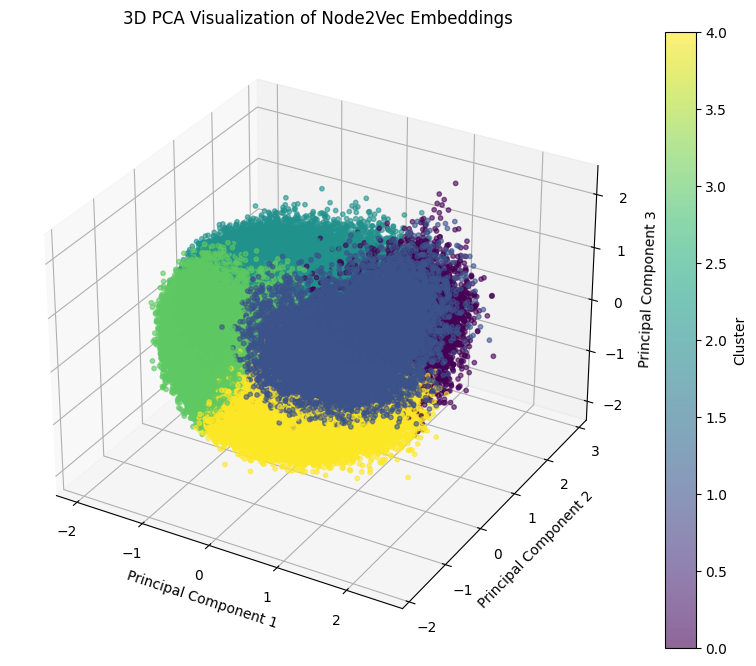

3D PCA visualization saved to: node2vec_pca_3d_clusters.png


In [7]:
import pickle
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plots

# Load embeddings
embedding_path = "/kaggle/input/n2v-rich/node2vec_embeddings_train (1).pkl"  # Replace if needed
with open(embedding_path, "rb") as f:
    embeddings = pickle.load(f)

# Convert to matrix
node_ids = list(embeddings.keys())
X = np.array([embeddings[nid] for nid in node_ids])

# PCA to 3D
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X)

# Clustering for color
kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(X)

# Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
    c=labels, cmap='viridis', s=10, alpha=0.6  # Transparency set here
)

ax.set_title("3D PCA Visualization of Node2Vec Embeddings")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")

plt.colorbar(scatter, label='Cluster')

# Save and display
output_path = "node2vec_pca_3d_clusters.png"
plt.savefig(output_path)
plt.show()

print(f"3D PCA visualization saved to: {output_path}")
